In [1]:
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Dropout,Conv2D,Conv2DTranspose,Activation,Flatten,LeakyReLU
from tensorflow.keras.models import Model
from IPython.display import clear_output
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import tqdm
import time
import cv2
import gc
import os

In [2]:
tf.config.list_physical_devices()
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
IMAGE_WIDTH = 1200
IMAGE_HEIGHT = 600
IMAGE_CHANNEL = 3
BATCH_SIZE = 1 
SEGMENT_PER_IMAGE = 4
EPOCHS = 100
AUTO_SAVE_PERIOT = 1
TRAIN_TOPIC = datetime.now().strftime("%m_%d-%H_%M")

IMAGES_PATH = './images_1'
TEST_IMAGES_PATH = './images_2'
global IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL,BATCH_SIZE,EPOCHS,IMAGES_PATH

In [4]:
TRAIN_TOPIC

'01_28-01_07'

## DATA

In [5]:
## total data file size
total = 0
for i in os.listdir(IMAGES_PATH):
    path = f"{IMAGES_PATH}/{i}"
    size = os.path.getsize(path)
    total += size

print(f"Dosyanın boyutu: {total / (1024 * 1024):.2f} MB")  # Megabyte

Dosyanın boyutu: 6119.75 MB


### PREPROCESS

In [6]:
#convertions
def add_loud(image,min_mean=-150,max_mean=150,max_sigma=300):
    mean = np.random.randint(min_mean,max_mean)
    sigma = np.random.randint(0,max_sigma)
        
    gaussian_noise = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    # Görüntüye gürültü ekleme
    noisy_image = cv2.add(image.astype(np.float32), gaussian_noise)
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

def add_cloud(image,
              min_opacity=0.4,
              max_opacity=0.7,
              min_cloud_count=1,
              max_cloud_count=3,
              min_cloud_size = 500,
              blur_kernel=(51, 51),
              blur_sigmaX=15,
              brightness_alpha=0, 
              min_brightness_sigma=120,
              max_brightness_sigma=220):
    # 1. Rastgele parlaklık ve saydamlık değerlerini seç
    opacity = np.random.uniform(min_opacity, max_opacity)
    brightness_sigma = np.random.randint(min_brightness_sigma, max_brightness_sigma)

    # 2. Görüntü boyutlarını al
    height, width, _ = image.shape

    def _create_cloud():
        # 3. Bulut boyutlarını rastgele belirle (100x100 ile görüntü boyutları arasında)
    
        cloud_height = np.random.randint(min_cloud_size, height) 
        cloud_width = np.random.randint(min_cloud_size, width)  
    
        # 4. Rastgele bir konum seç
        x_offset = np.random.randint(0, width - cloud_width)
        y_offset = np.random.randint(0, height - cloud_height)
    
        # 5. Boş bir görüntü oluştur ve gürültü ekle
        noise = np.random.normal(0, 1, (cloud_height, cloud_width)).astype(np.float32)
        # 6. Gürültüyü yumuşatarak bulanık yapıya dönüştür
        clouds = cv2.GaussianBlur(noise, blur_kernel, sigmaX=blur_sigmaX)
    
        # 7. Parlaklık seviyesini ve kontrastını ayarla
        clouds = cv2.normalize(clouds, None, alpha=brightness_alpha, beta=brightness_sigma, norm_type=cv2.NORM_MINMAX)
        clouds = clouds.astype(np.uint8)
    
        # 8. Bulutları bulanıklaştırarak yumuşat
        clouds = cv2.GaussianBlur(clouds, (41, 41), sigmaX=10)  # Tamamen bulanıklaştırma
    
        # 9. Kenar opaklığını azaltan bir maske oluştur (kenarlarda daha şeffaflık)
        mask = np.zeros((cloud_height, cloud_width), dtype=np.float32)
        center = (cloud_width // 2, cloud_height // 2)
        radius = min(cloud_width, cloud_height) // 2
        for y in range(cloud_height):
            for x in range(cloud_width):
                distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
                mask[y, x] = max(0, 1 - distance / radius)  # Kenarlarda şeffaflık artar
    
        # Maskeyi normalize et
        mask = cv2.GaussianBlur(mask, (41, 41), sigmaX=10)
        mask = np.clip(mask, 0, 1)
    
        # Maskeyi bulutlarla birleştir
        clouds = cv2.convertScaleAbs(clouds)
        cloud_rgb = cv2.cvtColor(clouds, cv2.COLOR_GRAY2RGB)
        cloud_rgb = np.uint8(cloud_rgb * mask[..., None])
    
        # 10. Ana görüntü üzerinde bulutların konumlandırılması
        cloud_layer = np.zeros_like(image, dtype=np.uint8)
        cloud_layer[y_offset:y_offset + cloud_height, x_offset:x_offset + cloud_width] = cloud_rgb

        return cloud_layer

    output = image.copy()
    cloud_layers = [ _create_cloud() for i in range(np.random.randint(min_cloud_count,max_cloud_count))]
    # 11. Saydamlık ile görüntüleri birleştir (Genel parlaklık değişmeden, sadece opaklık ile bulut eklenir)
    for layer in cloud_layers:
        output = cv2.addWeighted(output, 1, layer, opacity, 0)

    return output

def segment_im(im,sub_im_width=1200,sub_im_height=600):
    im_height,im_width,_ = im.shape
    top_left = im[0:sub_im_height,0:sub_im_width]    
    top_right = im[0:sub_im_height,im_width-sub_im_width:im_width]    
    bottom_left = im[im_height-sub_im_height:im_height,0:sub_im_width]    
    bottom_right = im[im_height-sub_im_height:im_height,im_width-sub_im_width:im_width]   

    return [top_left,top_right,bottom_left,bottom_right]

def scale_im(im):
    im = im / 255
    return im

def descale_im(im):
    im = im * 255
    im = im.astype(np.uint8)

    min_val = im.min()
    max_val = im.max()

    if min_val < 0 or max_val > 255:    
        # 0 ile 255 arasında ölçekleme yap
        im = ((im - min_val) / (max_val - min_val) * 255).astype('uint8')
        
    return im

### READING AND LOADING

In [7]:
total = 0
for i in os.listdir(IMAGES_PATH):
    total += os.path.getsize(f"{IMAGES_PATH}/{i}")
print(f"Dosyanın boyutu: {total / (1024 * 1024):.2f} MB")  # Megabyte

Dosyanın boyutu: 6119.75 MB


In [8]:
def import_data():
    images = []
    
    for i in tqdm.tqdm(os.listdir(IMAGES_PATH)[0:100]):
        path = f"{IMAGES_PATH}/{i}"
        images.append(cv2.imread(path))

    global BATCH_COUNT
    BATCH_COUNT = int(len(images) / BATCH_SIZE)
    print("Length of images: ",len(images))
    print("Batch Size:",BATCH_SIZE)
    print("Batch Count:",BATCH_COUNT)
    return images

def get_slice(data,start_idx,end_idx):
    images = data[start_idx:end_idx]

    origs,noisies = [],[]

    # get original images
    for image in images:
        origs.extend(list(segment_im(image)))

    origs = np.array(origs)
    # gauss loud or cloud loud type selection    
    process_type = np.random.randint(0,2)
    # get noisy images
    for im in origs:
        if process_type == 0:
            noisy_image = add_loud(im)
            noisies.append(noisy_image)
        elif process_type == 1:
            noisy_image = add_cloud(im)
            noisies.append(noisy_image)
    noisies = np.array(noisies)
    
    y_true = np.ones(shape=(BATCH_SIZE* SEGMENT_PER_IMAGE))
    y_false = np.zeros(shape=(BATCH_SIZE * SEGMENT_PER_IMAGE))
    return origs,y_true,noisies,y_false


## MODEL

### GENERATOR

In [9]:
def create_generator():
    inp = Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL))

    x = Conv2D(24,(5,5),(2,2),padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(24,(3,3),(2,2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(24,(3,3),(2,2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(24,(3,3),(2,2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2DTranspose(24,(3,3),(2,2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    out = Conv2DTranspose(3,(5,5),(2,2),padding='same',activation='sigmoid')(x)

    return Model(inp,out,name='generator')

gen_model = create_generator()
gen_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 1200, 3)]    0         
                                                                 
 conv2d (Conv2D)             (None, 300, 600, 24)      1824      
                                                                 
 batch_normalization (BatchN  (None, 300, 600, 24)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 300, 600, 24)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 300, 24)      5208      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 300, 24)     96        
 hNormalization)                                         

### DISCRIMINATOR

In [10]:
def create_discriminator():
    inp = Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL))

    x = Conv2D(12,(5,5),(3,3))(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(12,(5,5),(3,3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(12,(5,5),(3,3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(1,activation='sigmoid')(x)

    return Model(inp,x,name='discriminator')

disc_model = create_discriminator()
disc_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600, 1200, 3)]    0         
                                                                 
 conv2d_3 (Conv2D)           (None, 199, 399, 12)      912       
                                                                 
 batch_normalization_5 (Batc  (None, 199, 399, 12)     48        
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 199, 399, 12)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 65, 132, 12)       3612      
                                                                 
 batch_normalization_6 (Batc  (None, 65, 132, 12)      48        
 hNormalization)                                     

### GENERAL MODEL

In [11]:
from tensorflow.keras.optimizers import Adam
def create_general(model_gen,model_disc):
    disc_opt = Adam(learning_rate=0.0002,beta_1=0.5)
    general_opt = Adam(learning_rate=0.0002,beta_1=0.5)
    
    model_disc.compile(loss='binary_crossentropy',optimizer=disc_opt,metrics=['accuracy'])
    model_disc.trainable = False

    gen_input = model_gen.input
    gen_output = model_gen.output
    general_output = model_disc(gen_output)
    model =Model(gen_input,general_output)
    
    
    model.compile(loss='binary_crossentropy',optimizer=general_opt)
    return model

general = create_general(gen_model,disc_model)
general.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 1200, 3)]    0         
                                                                 
 conv2d (Conv2D)             (None, 300, 600, 24)      1824      
                                                                 
 batch_normalization (BatchN  (None, 300, 600, 24)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 300, 600, 24)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 300, 24)      5208      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 300, 24)     96        
 hNormalization)                                             

### TRAINING


In [12]:
# ayırıcı ağ bir orijinal veri ile eğitilir [orijinal->1]
# ayırıcı ağ bir gürültülü veri ile eğitilir [gürültülü->0]
# tüm ağı generatorü eğtmek için eğit gürültülü veri ile orijinal olduğunu düşündür.
# Generator'ı eğitmek için sahte görüntülerin "gerçek" olduğunu düşündür [gürültülü->1]

In [13]:
def save_checkpoint(epoch,g_model,d_model,g_loss,d_loss_r,d_loss_f,sample_real,sample_noisy,sample_estimated):
    # model save
    g_model.save(f'./training/generator/{TRAIN_TOPIC}_{epoch}.h5')
    d_model.save(f'./training/discriminator/{TRAIN_TOPIC}_{epoch}.h5')

    # metrics save
    f = open('./training/checkpoint.txt','a')
    f.writelines(f"\ntrain:{TRAIN_TOPIC} epoch:{epoch} g_loss:{g_loss:.7f} d_loss_r:{d_loss_r:.7f} d_loss_f:{d_loss_f:.7f}")
    f.close()

    # sample save
    sample = np.zeros((IMAGE_HEIGHT*2,IMAGE_WIDTH*2,3), dtype=np.uint8)
    sample[0:IMAGE_HEIGHT,0:IMAGE_WIDTH] = sample_real
    sample[0:IMAGE_HEIGHT,IMAGE_WIDTH:IMAGE_WIDTH*2] = sample_noisy
    sample[IMAGE_HEIGHT:IMAGE_HEIGHT*2,0:IMAGE_WIDTH] = sample_estimated
    cv2.imwrite(f'./training/samples/{TRAIN_TOPIC}_{epoch}.jpg',sample)
    

def show_outputs(original,noisy,estimation,g_loss_history,d_loss_real_history,d_loss_fake_history):
    epochs_history = range(len(g_loss_history))

    plt.figure(figsize=(10,7))    
    plt.subplot(1, 4, 1); plt.imshow(cv2.cvtColor(original,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Original')
    plt.subplot(1, 4, 2); plt.imshow(cv2.cvtColor(noisy,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Noisy')
    plt.subplot(1, 4, 3); plt.imshow(cv2.cvtColor(estimation,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Estimation-rev')
    plt.subplot(1, 4, 4); plt.imshow(estimation); plt.axis("off");plt.title('Estimation')
    plt.tight_layout()  # Görseller arasındaki boşlukları düzenle
    plt.show()

    # Çizgi grafiği oluşturma
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_history, g_loss_history, label='Generator Loss (g_loss)', color='blue', marker='o')
    plt.plot(epochs_history, d_loss_real_history, label='Discriminator Loss (Real) (d_loss_real)', color='green', marker='s')
    plt.plot(epochs_history, d_loss_fake_history, label='Discriminator Loss (Fake) (d_loss_fake)', color='red', marker='^')
    
    # Grafik ayarları
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    
    # Yakın Çizgi grafiği
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_history, g_loss_history, label='Generator Loss (g_loss)', color='blue', marker='o')
    plt.plot(epochs_history, d_loss_real_history, label='Discriminator Loss (Real) (d_loss_real)', color='green', marker='s')
    plt.plot(epochs_history, d_loss_fake_history, label='Discriminator Loss (Fake) (d_loss_fake)', color='red', marker='^')
    plt.ylim(0, np.concatenate((g_loss_history[-5:],d_loss_real_history[-5:],d_loss_fake_history[-5:])).max())
    
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:

#general losses
d_real_losses = []
d_fake_losses = []
g_losses = []

global d_real_losses,d_fake_losses,g_losses

def train_gan(generator,discriminator,gan_model,data):
    tf.keras.backend.clear_session()
    show_idx = 0


    for i in tqdm.tqdm(range(EPOCHS)):
        ep_start_time = time.time()
        # losses per sub epoch
        d_real_losses_per_epoch = []
        d_fake_losses_per_epoch = []
        g_losses_per_epoch = []


        for k in tqdm.tqdm(range(BATCH_COUNT)):
            ### TRAINING
            originals,y_true,noisies,y_false= get_slice(data,k*BATCH_SIZE,k*BATCH_SIZE+BATCH_SIZE)
            # scale images
            originals = np.array(list(map(scale_im,originals)) )
            noisies = np.array(list(map(scale_im,noisies)))

            estimations=generator.predict(originals)
        
            d_loss_real,d_acc_real = discriminator.train_on_batch(originals, y_true)
            d_loss_fake,d_acc_fake = discriminator.train_on_batch(estimations, y_false)

            g_loss = gan_model.train_on_batch(noisies, y_true)
                        
            # sub losses
            d_real_losses_per_epoch.append(d_loss_real)
            d_fake_losses_per_epoch.append(d_loss_fake)
            g_losses_per_epoch.append(g_loss)
            
        # mean of sub losses going to main loss lists
        mean_g_loss = np.mean(g_losses_per_epoch)
        mean_d_loss_real = np.mean(d_real_losses_per_epoch)
        mean_d_loss_fake = np.mean(d_fake_losses_per_epoch)
        
        g_losses.append(mean_g_loss)
        d_real_losses.append(mean_d_loss_real)
        d_fake_losses.append(mean_d_loss_fake)

        #outputs
        clear_output()
        show_outputs(descale_im(originals[show_idx]),descale_im(noisies[show_idx]),descale_im(estimations[show_idx]),g_losses,d_real_losses,d_fake_losses)

        print("EPOCH:",i)
        print("G_LOSS:",mean_g_loss)
        print("D_REAL_LOSS:",mean_d_loss_real)
        print("D_FAKE_LOSS:",mean_d_loss_fake)
        print("USED VRAM MEMORY: ",tf.config.experimental.get_memory_info('GPU:0'))  # VRAM bilgisi
        print("ELAPSED TIME: ",time.time()-ep_start_time)
        # Bellek temizliği
        gc.collect()
        K.clear_session()

        # save
        if i % AUTO_SAVE_PERIOT == 0:
            save_checkpoint(i,generator,discriminator,mean_g_loss,mean_d_loss_real,mean_d_loss_fake,descale_im(originals[show_idx]),descale_im(noisies[show_idx]),descale_im(estimations[show_idx]))
            

### TRAIN

In [15]:
data = import_data()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 126.51it/s]

Length of images:  100
Batch Size: 1
Batch Count: 100


In [16]:
print(disc_model.optimizer.learning_rate)
print(general.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0002>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0002>


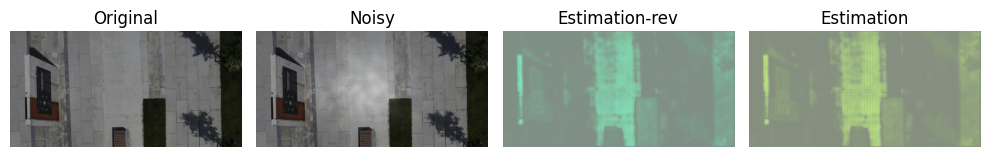

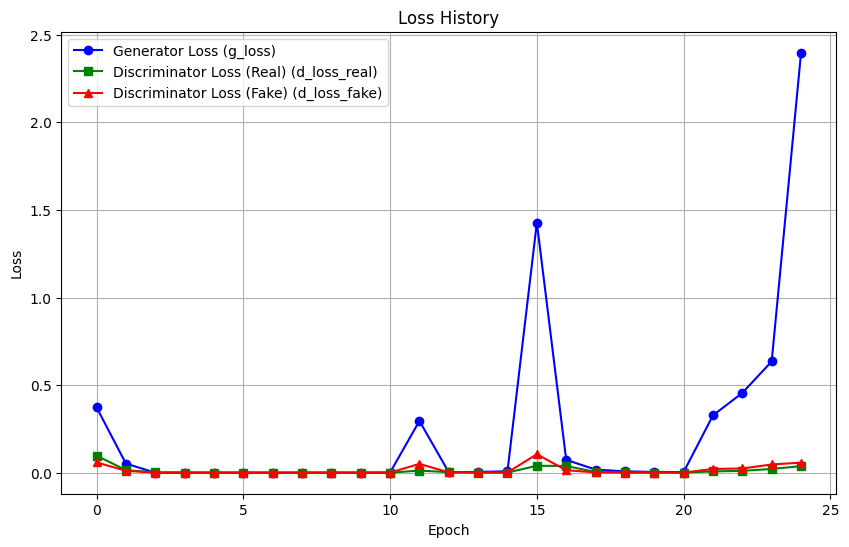

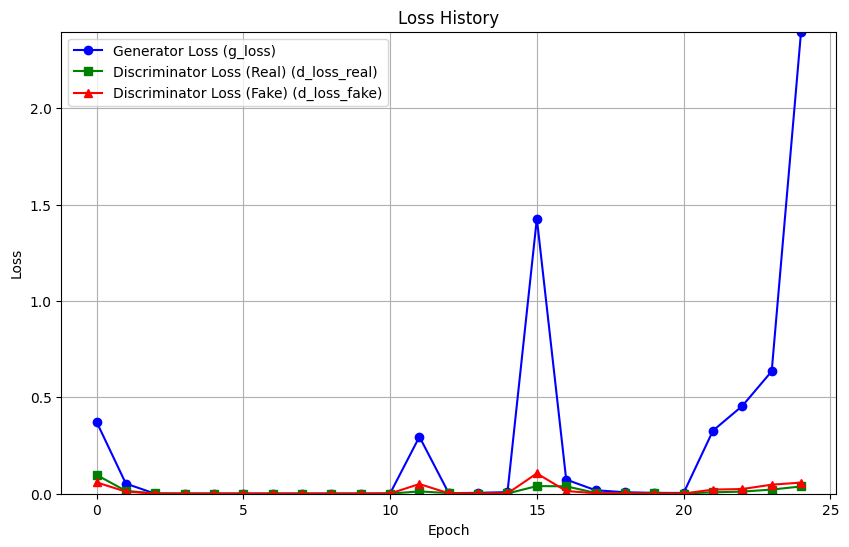

EPOCH: 24
G_LOSS: 2.397444226808708
D_REAL_LOSS: 0.037677824938800765
D_FAKE_LOSS: 0.05763339682899627
USED VRAM MEMORY:  {'current': 372717824, 'peak': 1502297600}
ELAPSED TIME:  309.18502736091614


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 101ms/step



  1%|▊                                                                                 | 1/100 [00:06<10:22,  6.29s/it]

1/1 [==============================] - 0s 31ms/step



  2%|█▋                                                                                | 2/100 [00:09<07:26,  4.55s/it]

1/1 [==============================] - 0s 35ms/step



  3%|██▍                                                                               | 3/100 [00:10<04:32,  2.81s/it]

1/1 [==============================] - 0s 33ms/step



 25%|███████████████████                                                         | 25/100 [2:02:14<6:06:44, 293.39s/it]


KeyboardInterrupt: 

In [17]:
train_gan(gen_model,disc_model,general,data)

## TRANSFER TRAINING


In [ ]:
data = import_data()

In [ ]:
MODEL_NAME = "01_27-11_41_9.h5"
DISC_MODEL_PATH = "./training/discriminator"
GEN_MODEL_PATH = "./training/generator"

disc_model = tf.keras.models.load_model(f"{DISC_MODEL_PATH}/{MODEL_NAME}")
gen_model = tf.keras.models.load_model(f"{GEN_MODEL_PATH}/{MODEL_NAME}")
general_model = create_general(gen_model,disc_model)

In [ ]:
print(disc_model.optimizer.learning_rate)
print(general_model.optimizer.learning_rate)

In [ ]:
disc_model.optimizer.learning_rate = 0.0005
general_model.optimizer.learning_rate = 0.00005

In [ ]:
train_gan(gen_model,disc_model,general_model,data)

## TEST MODELS

In [ ]:
### EVALUATION

In [ ]:
def import_test_data():
    images = []
    
    for i in tqdm.tqdm(os.listdir(TEST_IMAGES_PATH)[0:100]):
        path = f"{TEST_IMAGES_PATH}/{i}"
        images.append(cv2.imread(path))
        
    print("Length of images: ",len(images))
    return images

def predict_im(image,model):
    t1_im = add_loud(image)
    t2_im = add_cloud(image)
    
    t1_im_scaled = scale_im(t1_im)
    t2_im_scaled = scale_im(t2_im)
    
    res_1,res_2 = model.predict(np.array([t1_im_scaled,t2_im_scaled]))
    
    res_1 = np.uint8(descale_im(res_1))
    res_2 = np.uint8(descale_im(res_2))

    return t1_im,t2_im,res_1,res_2
    

In [ ]:
test_data = import_test_data()
chosen = test_data[50]
chosen,_,_,_ = segment_im(chosen)
noisy,cloudy,est_noisy,est_cloudy = predict_im(chosen,gen_model)

print(noisy.shape)
#show
plt.figure(figsize=(10,7))
plt.subplot(1, 5, 1); plt.imshow(cv2.cvtColor(chosen,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Original')
plt.subplot(1, 5, 2); plt.imshow(cv2.cvtColor(noisy,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Noisy')
plt.subplot(1, 5, 3); plt.imshow(cv2.cvtColor(est_noisy,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Estimation Noisy')
plt.subplot(1, 5, 4); plt.imshow(cv2.cvtColor(cloudy,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Cloudy')
plt.subplot(1, 5, 5); plt.imshow(cv2.cvtColor(est_cloudy,cv2.COLOR_BGR2RGB)); plt.axis("off");plt.title('Estimation Cloudy')

plt.tight_layout()  # Görseller arasındaki boşlukları düzenle
plt.show()

test_win = np.zeros(shape=(IMAGE_HEIGHT,IMAGE_WIDTH*5,3))
test_win[:,:IMAGE_WIDTH] = chosen
test_win[:,IMAGE_WIDTH:IMAGE_WIDTH*2] = noisy
test_win[:,IMAGE_WIDTH*2:IMAGE_WIDTH*3] = est_noisy

test_win[:,IMAGE_WIDTH*3:IMAGE_WIDTH*4] = cloudy
test_win[:,IMAGE_WIDTH*4:] = est_cloudy

TOPIC = datetime.now().strftime("%m_%d-%H_%M")
cv2.imwrite(f"./tests/{TOPIC}.jpg",test_win)
print("test image saved:" + f"./tests/{TOPIC}.jpg" )

In [ ]:
cv2.imshow("1",descale_im(scale_im(chosen)))
cv2.waitKey(0)